In [9]:
from IPython.display import Image
import json

# WF2 Mod1A 

In [4]:
import pandas as pd
import graphviz as gv
from pprint import pprint
import requests
from functools import reduce

In [22]:
input_disease = 'MONDO:0019391' # Fanconi anemia 
# load set of gene ids from module 0 (disease-gene lookup)
input_curie_set = ''
with open('input_curie_set.json', 'r') as ics:
    input_curie_set = json.load(ics)

In [23]:

input_curie_set

[{'hit_id': 'HGNC:1100', 'hit_symbol': 'BRCA1'},
 {'hit_id': 'HGNC:1101', 'hit_symbol': 'BRCA2'},
 {'hit_id': 'HGNC:20473', 'hit_symbol': 'BRIP1'},
 {'hit_id': 'HGNC:3436', 'hit_symbol': 'ERCC4'},
 {'hit_id': 'HGNC:3582', 'hit_symbol': 'FANCA'},
 {'hit_id': 'HGNC:3583', 'hit_symbol': 'FANCB'},
 {'hit_id': 'HGNC:3584', 'hit_symbol': 'FANCC'},
 {'hit_id': 'HGNC:3585', 'hit_symbol': 'FANCD2'},
 {'hit_id': 'HGNC:28623', 'hit_symbol': 'FANCD2OS'},
 {'hit_id': 'HGNC:3586', 'hit_symbol': 'FANCE'},
 {'hit_id': 'HGNC:3587', 'hit_symbol': 'FANCF'},
 {'hit_id': 'HGNC:3588', 'hit_symbol': 'FANCG'},
 {'hit_id': 'HGNC:25568', 'hit_symbol': 'FANCI'},
 {'hit_id': 'HGNC:20748', 'hit_symbol': 'FANCL'},
 {'hit_id': 'HGNC:23168', 'hit_symbol': 'FANCM'},
 {'hit_id': 'HGNC:6764', 'hit_symbol': 'MAD2L2'},
 {'hit_id': 'HGNC:26144', 'hit_symbol': 'PALB2'},
 {'hit_id': 'HGNC:9817', 'hit_symbol': 'RAD51'},
 {'hit_id': 'HGNC:9820', 'hit_symbol': 'RAD51C'},
 {'hit_id': 'HGNC:25539', 'hit_symbol': 'RFWD3'},
 {'hit_

# Mod1A Functional Similarity
## Find similar genes based on GO functional annotations using OntoBio Jaccard similarity

The functional similarity module takes the functional annotations for each gene associated with the input disease (in this case Gene Ontology terms), and does a comparison of functional associations to all other genes in the human genome.  Gene functions are curated from literature and assigned to genes using the Gene Ontology. If a gene has a set of functions assigned to it, that set of functions can be pairwise compared to the sets of functions in every gene to determine a similarity score based on Jaccard Index. A simple algorithm that computes the length of the intersection of 2 sets over the length of their union.  

The ontology structure of the Gene Ontology is leveraged to include a higher level of context and meaning associated with each term annotated to the genes.  For example, two genes might have very similar terms, but not exact matches.  If Jaccard Index was used to compare those annotations at face value, they would not add be computed as similar in any way.  If the structure of the ontology is taken in to consideration then the two terms would be found to share a common close ancestor, and those ancestoral terms would be taken into consideration adding to similarity when the analysis is computed.

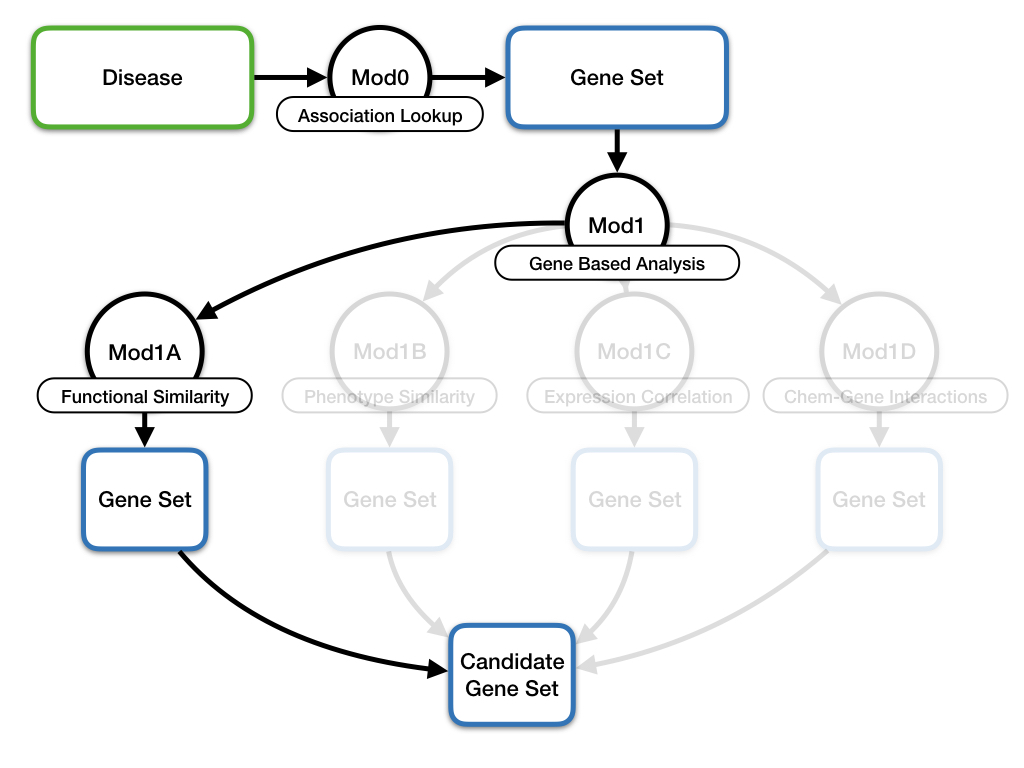

In [5]:
Image('Figures/Figures.014.jpeg')

In [6]:
from Modules.Mod1A_functional_sim import FunctionalSimilarity

# Module instantiation
Here the functional similarity module is instantiated with a standard configuration object that includes the set of input genes as well as a threshold for the Jaccard index required to return a result.

In [14]:
# Module specification
mod1a_input_object_human = {
    'input': input_curie_set,
    'parameters': {
        'taxon': 'human',
        'threshold': 0.85,  # jaccard index threshold
    },
}
    
func_sim_human = FunctionalSimilarity()

Mod1A Functional Similarity metadata:
{'input_type': {'complexity': 'set', 'data_type': 'gene', 'id_type': 'HGNC'},
 'output_type': {'complexity': 'set', 'data_type': 'gene', 'id_type': 'HGNC'},
 'predicate': ['blm:macromolecular machine to biological process association',
               'macromolecular machine to molecular activity association'],
 'source': 'Monarch Biolink'}


In [15]:
func_sim_human.load_input_object(mod1a_input_object_human)
func_sim_human.load_gene_set() 

In [16]:
func_sim_human.load_associations()

In [17]:
mod1a_results = func_sim_human.compute_similarity()

In [18]:
mod1a_df = pd.DataFrame(mod1a_results)
mod1a_df = mod1a_df[mod1a_df['hit_symbol'] != mod1a_df['input_symbol']]

# Results
Below are the results, a table of 'hits' that have a functional similarity Jaccard Index > .85 to any of the genes from the input gene set.

In [19]:
mod1a_df

,hit_id,hit_symbol,input_id,input_symbol,score
5,HGNC:26171,FAAP100,HGNC:3583,FANCB,0.857143
6,HGNC:21700,RAD9B,HGNC:3583,FANCB,0.920000
8,HGNC:3586,FANCE,HGNC:3583,FANCB,0.916667
9,HGNC:3587,FANCF,HGNC:3583,FANCB,1.000000
10,HGNC:24994,INIP,HGNC:3583,FANCB,0.851852
13,HGNC:3583,FANCB,HGNC:3586,FANCE,0.916667
15,HGNC:3587,FANCF,HGNC:3586,FANCE,0.916667
16,HGNC:26171,FAAP100,HGNC:3587,FANCF,0.857143
17,HGNC:21700,RAD9B,HGNC:3587,FANCF,0.920000
18,HGNC:3583,FANCB,HGNC:3587,FANCF,1.000000


In [20]:
def format_curie(curie):
    return curie.replace(':', '_')

In [24]:
fa = format_curie(input_disease)

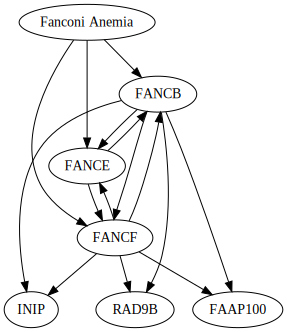

In [25]:
m1a_graph = gv.Digraph(name='Mod1A', format='png', strict=True)
m1a_graph.node(fa, label='Fanconi Anemia')
for index, row in mod1a_df.iterrows():
    m1a_graph.node(format_curie(row[0]), label=row[1])
    m1a_graph.node(format_curie(row[2]), label=row[3])
    m1a_graph.edge(fa, format_curie(row[2]))
    m1a_graph.edge(format_curie(row[2]), format_curie(row[0]))
m1a_graph   

In [26]:
inip_result_df = mod1a_df[mod1a_df['hit_symbol'] == 'INIP']

In [27]:
inip_result_df

,hit_id,hit_symbol,input_id,input_symbol,score
10,HGNC:24994,INIP,HGNC:3583,FANCB,0.851852
21,HGNC:24994,INIP,HGNC:3587,FANCF,0.851852


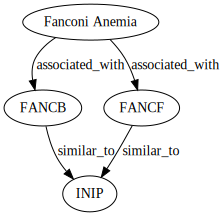

In [28]:
inip_graph = gv.Digraph(name='INIP', format='png', strict=True)
inip_graph.node(fa, label='Fanconi Anemia')
for index, row in inip_result_df.iterrows():
    inip_graph.node(format_curie(row[0]), label=row[1])
    inip_graph.node(format_curie(row[2]), label=row[3])
    inip_graph.edge(fa, format_curie(row[2]), label='associated_with')
    inip_graph.edge(format_curie(row[2]), format_curie(row[0]), label='similar_to')
inip_graph   

In [29]:
uniprot_map = {
    'INIP': 'UniProtKB:Q9NRY2',
    'FANCB': 'UniProtKB:Q8NB91'
}

In [31]:
inip_functions = [
    {
        'label': func_sim_human.ontology.label(x), 
        'id': x
    } for x in func_sim_human.associations.annotations(uniprot_map['INIP']) ]
fancb_functions = [
    {
        'label': func_sim_human.ontology.label(x), 
        'id': x,
    } for x in func_sim_human.associations.annotations(uniprot_map['FANCB']) ]

In [32]:
def graph_functions(input_node, annotations, graph):
    for anno in annotations:
        graph.node(format_curie(anno['id']), anno['label'])
        graph.edge(format_curie(input_node), format_curie(anno['id']), label='has_function')

In [33]:
graph_functions('HGNC:24994', inip_functions, inip_graph)
graph_functions('HGNC:3583', fancb_functions, inip_graph)

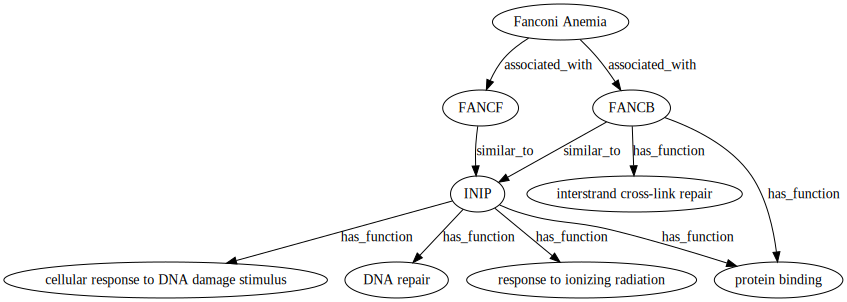

In [34]:
inip_graph

In [35]:
fancb_inferred_functions = []
for bfunc in fancb_functions:
    fancb_inferred_functions = fancb_inferred_functions + func_sim_human.ontology.ancestors(bfunc['id'], reflexive=True)

In [36]:
inip_inferred_functions = []
for ifunc in inip_functions:
    inip_inferred_functions = inip_inferred_functions + func_sim_human.ontology.ancestors(ifunc['id'], reflexive=True)

In [37]:
function_graph = gv.Digraph(name='Function Graph', strict=True, format='png', engine='circo')
function_graph.node( format_curie('HGNC:24994'),label='INIP',color='blue', shape='box', fontsize='25')
function_graph.node( format_curie('HGNC:3583'),label='FANCB',color='blue', shape='box', fontsize='25')

In [38]:
for index, ifunc in enumerate(inip_inferred_functions):
    try:
        function_graph.node(format_curie(ifunc), label=func_sim_human.ontology.label(ifunc))
        function_graph.edge(format_curie('HGNC:24994'), format_curie(ifunc))
    except Exception as e:
        print(e)
for index, bfunc in enumerate(fancb_inferred_functions):
    try:
        function_graph.node(format_curie(bfunc), label=func_sim_human.ontology.label(bfunc))
        function_graph.edge(format_curie('HGNC:3583'), format_curie(bfunc))
    except Exception as e:
        print(e)

In [39]:
function_graph.render()

'Function Graph.gv.png'

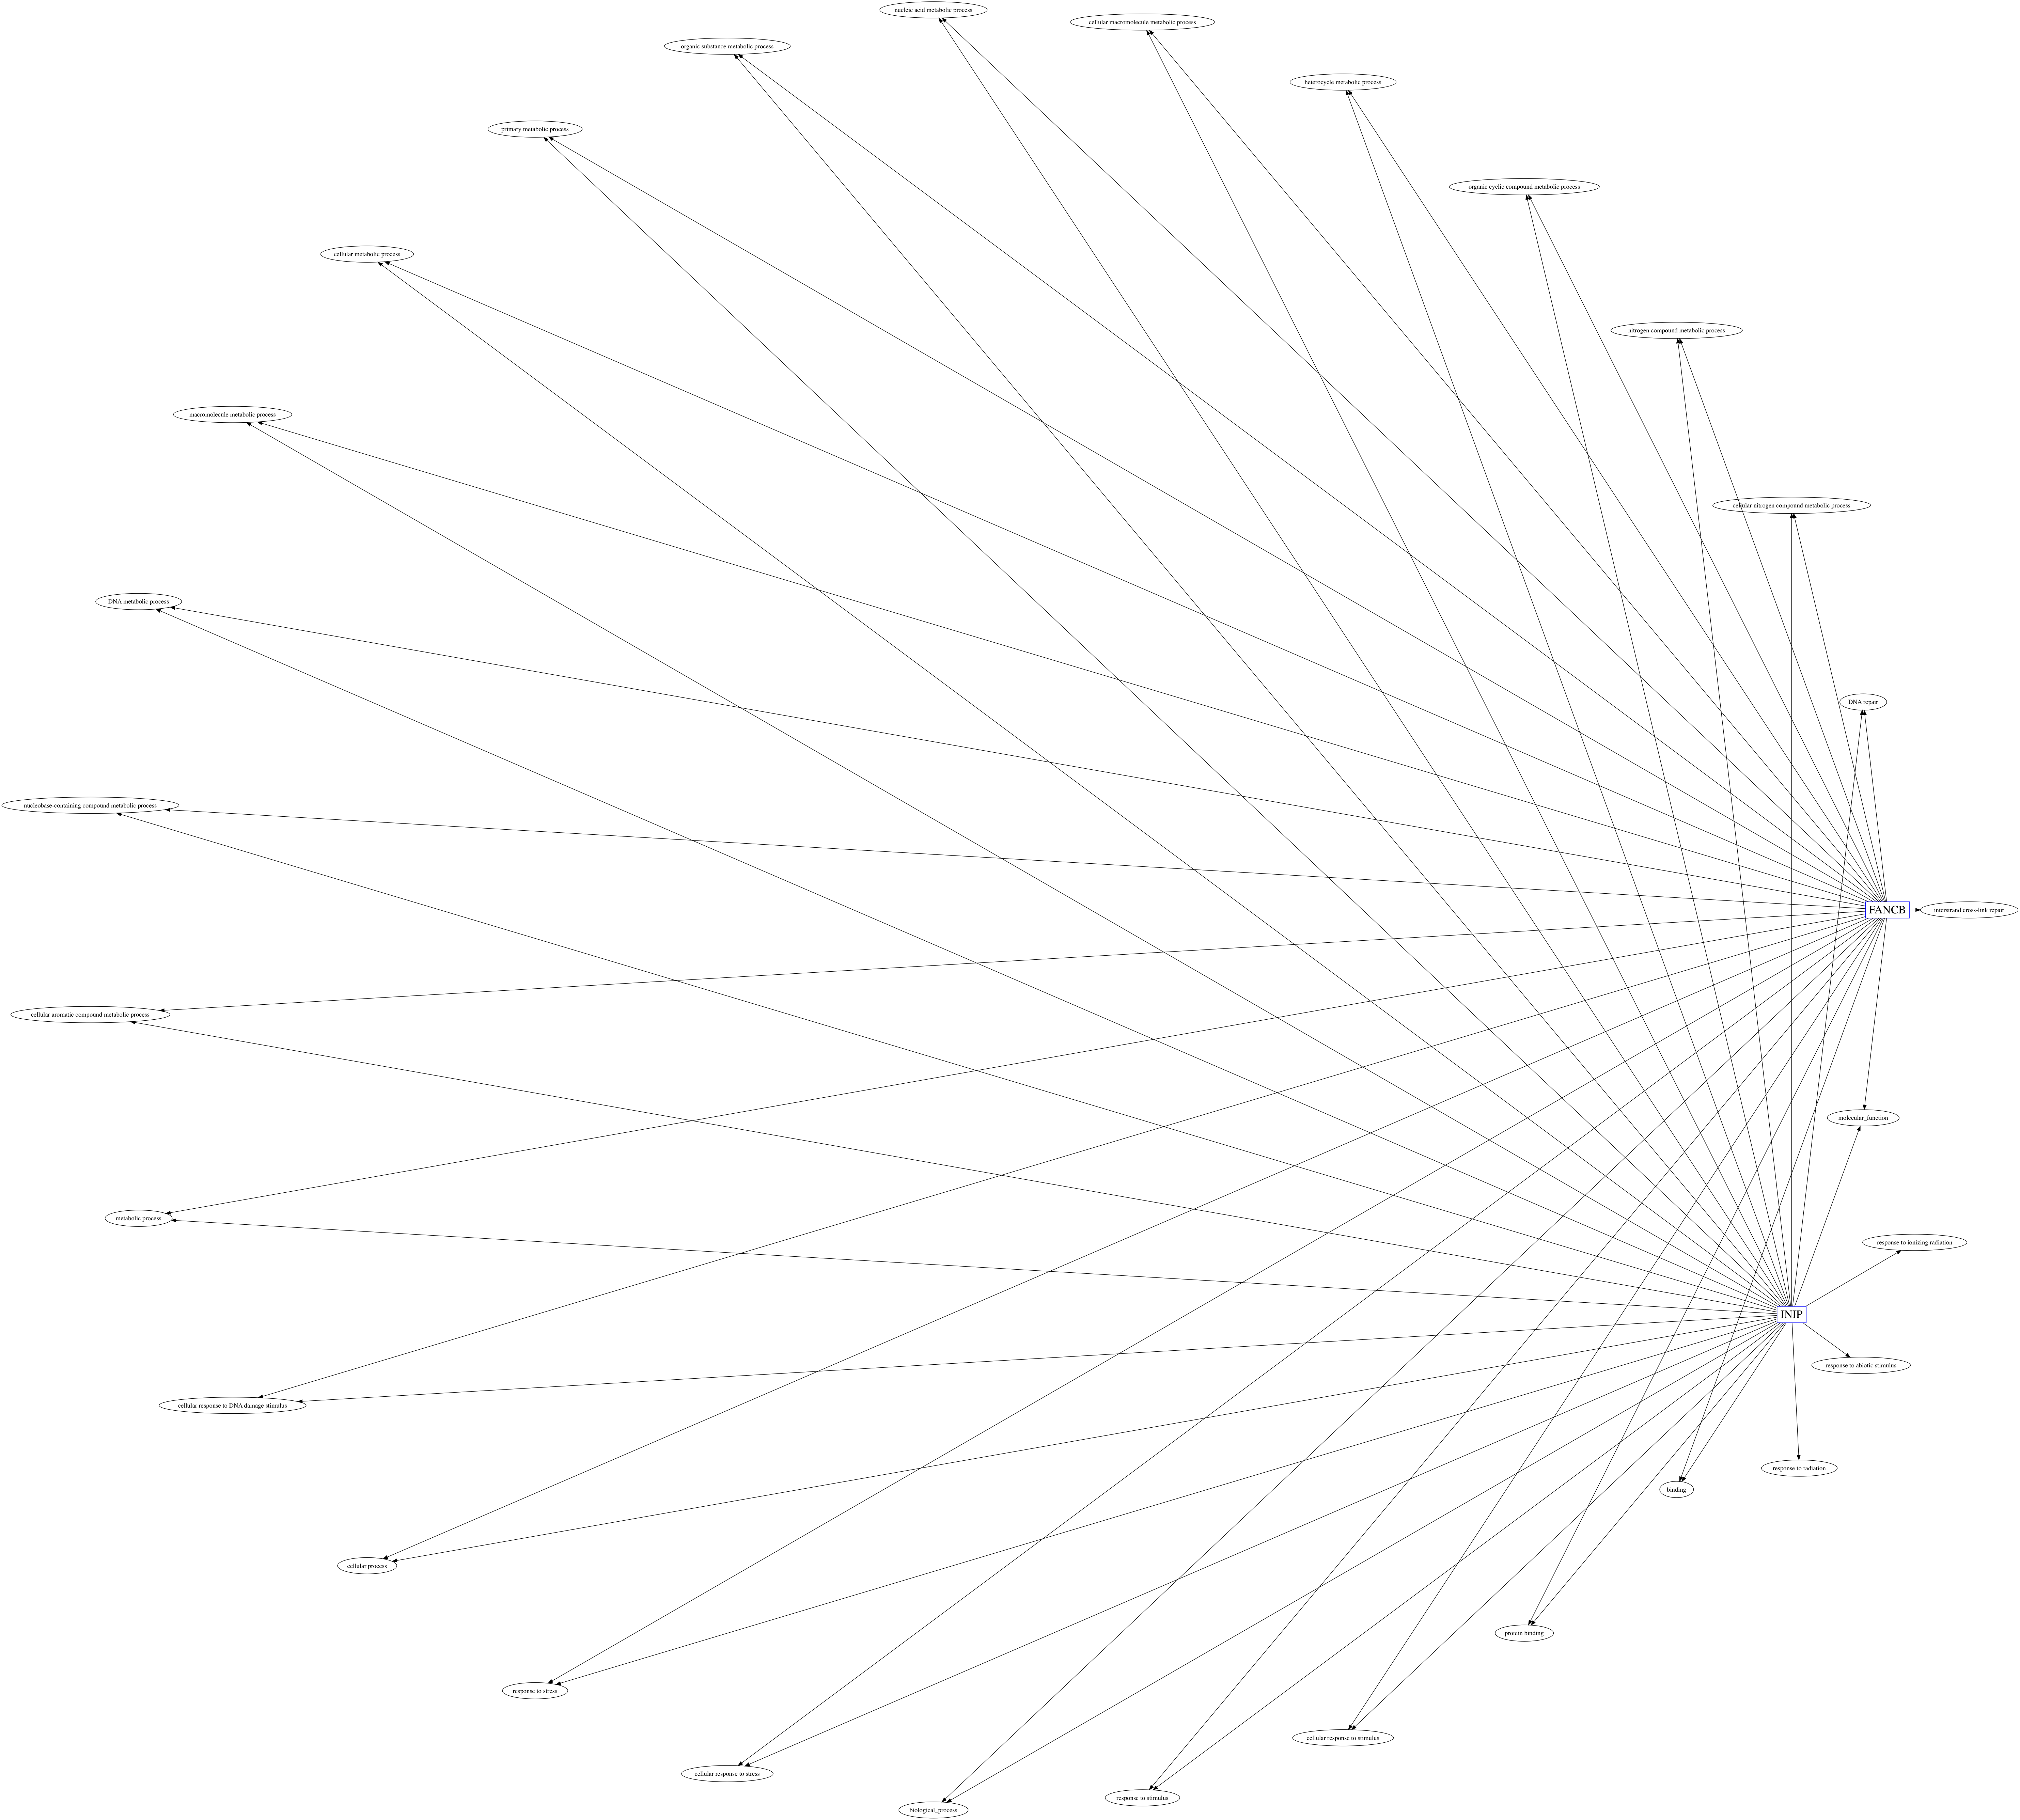

In [40]:
Image('Function Graph.gv.png')

# Analysis of example output

Candidate: INIP (INST3- AND NABP-INTERACTING PROTEIN, aka chromosome 9 open reading frame 80; c9orf80 sensor of single-stranded dna complex, subunit c; sossc Soss complex, subunit c

Note here that the various names of the protein/gene are difficult to follow using literature. Further complicating is that many genes orthologs have different names in different species. This is important because for the first time, translator can perform analyses using datasets in several species, particularly with the Monarch knowledge graph. Some functional connections may have been discovered in lower organisms and thus these analyses could be expected to give insight into the human protein function.

Supporting experimental functional relevance for INIP in FA.

Matches with the G2/M arrest observed in FA cells.

INIP is a component of the SOSS complex, a multiprotein complex that functions downstream of the MRN complex to promote DNA repair and G2/M checkpoint.

The SOSS complex associates with single-stranded DNA at DNA lesions and influences diverse endpoints in the cellular DNA damage response including cell-cycle checkpoint activation, recombinational repair and maintenance of genomic stability.

Required for efficient homologous recombination-dependent repair of double-strand breaks (DSBs) and ATM-dependent signaling pathways.

https://www.genecards.org/cgi-bin/carddisp.pl?id_type=hgnc&id=24994

INST3- AND NABP-INTERACTING PROTEIN; INIP has been found in screens for Parp inhibotr sensitivity, which is an emerging functional connection with Fanconi, see: http://cancerres.aacrjournals.org/content/canres/suppl/2013/11/18/0008-5472.CAN-13-2541.DC1/supp_table_4.pdf

Matches with the phenotype of replication stress and bone marrow failure in Fanconi.

“Ssb1 and Ssb2 cooperate to regulate mouse hematopoietic stem and progenitor cells by resolving replicative stress.” http://www.bloodjournal.org/content/129/18/2479?sso-checked=true

The actual role of C9ORF80 remains unknown, making it an interesting candidate to further explore as a possible FA modifier. https://www.ncbi.nlm.nih.gov/pubmed/29150435